# Homework 3 - Deep Learning

## Задание 9

Обучите полносвязную нейронную сеть для классификации на датасете MNIST. Добейтесь качества в 98% на тестовой выборке.

Можете использовать уже написанные ранее функции train и evaluate.

Чтобы мы могли проверить вашу модель, напишите функцию, которая создает вашу модель и возвращает объект, назовите функцию create_mlp_model, без аргументов. Вам понадобится сохранить веса вашей модели и сдать их в тестировщик, для этого воспользуйтесь методами torch.save и state_dict.aa

## Импорт библиотек

In [11]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

import importlib
task3 = importlib.import_module("3 - ConvNets")
task2 = importlib.import_module("2 - NeuralOptim")

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## Импорт датасета

In [65]:
mnist_train = MNIST(
    "../../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor() # чтобы переводился сразу в тензорный объект
)

mnist_test = MNIST(
    '../../datasets/mnist',
    train=False,
    download=True,
    transform=T.ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 23322681.23it/s]


Extracting ../../datasets/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ../../datasets/mnist\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 5572531.69it/s]


Extracting ../../datasets/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ../../datasets/mnist\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5987048.69it/s]


Extracting ../../datasets/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ../../datasets/mnist\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../../datasets/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../datasets/mnist\MNIST\raw



In [31]:
mnist_train[0][0].shape


torch.Size([1, 28, 28])

Итак, датасет содержит картинки размером 28х28 пикселей

In [30]:
# добавляем loader

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

## Задание 9

Обучите полносвязную нейронную сеть для классификации на датасете MNIST. Добейтесь качества в 98% на тестовой выборке.

Можете использовать уже написанные ранее функции train и evaluate.

Чтобы мы могли проверить вашу модель, напишите функцию, которая создает вашу модель и возвращает объект, назовите функцию create_mlp_model, без аргументов. Вам понадобится сохранить веса вашей модели и сдать их в тестировщик, для этого воспользуйтесь методами torch.save и state_dict.aa

Создавать модель будем по следующему алгоритму:
1. Начинаем с уплощения входных данных - линейный слой требует только количество входных и выходных фичей, никакой двумерщины
2. Линейный слой. Количество входных фичей по количеству пикселей - 28*28. Выходных - произвольное $N$
3. Функция активации ReLU
4. Линейный слой. Количество входных фичей - $N$, выходных - по количеству классов (в нашем случае 10 цифр - 10 классов)

Добавим оптимизатор Adam и функционал потерь CrossEnthropy

In [37]:
# создаем функцию для создания нейросети

def create_mlp_model():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=28*28, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10)
    )

model_fcn = create_mlp_model()

optimizer = torch.optim.Adam(model_fcn.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [53]:
# добавим функции из ноутбука практики
def plot_stats(train_loss: list,
               valid_loss: list,
               valid_accuracy: list,
               title: str
               ):
    
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()


def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn):
    model.to(device)
    model.train()
    total_loss = 0
    for x, y in tqdm(data_loader, desc='Training'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()  # zeroing gradients
        output = model(x)  # forward pass
        loss = loss_fn(output, y)  # count loss
        total_loss += loss.item()  # writing current loss
        loss.backward()  # backward pass
        # print(round(loss.item(), 5))  # print current loss
        optimizer.step()  # optimization step
    return total_loss / len(data_loader)


@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy


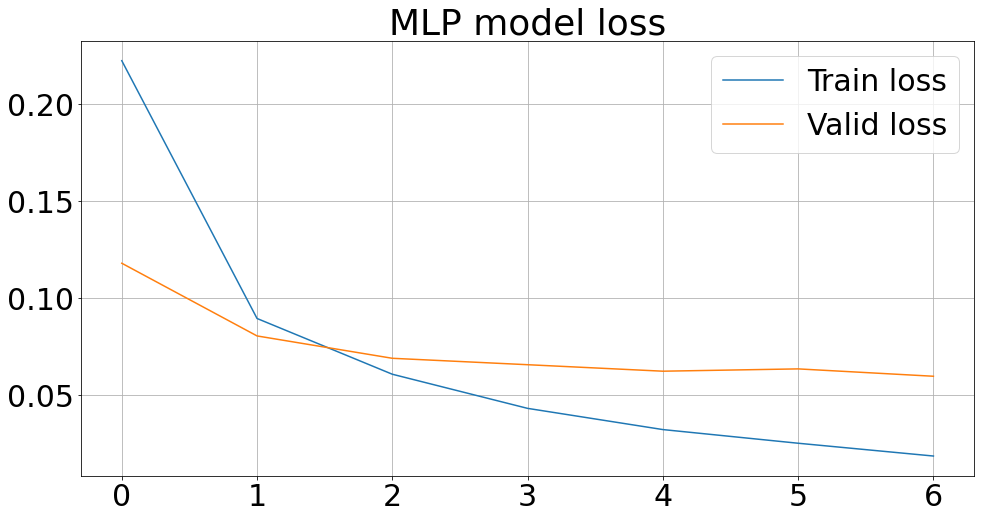

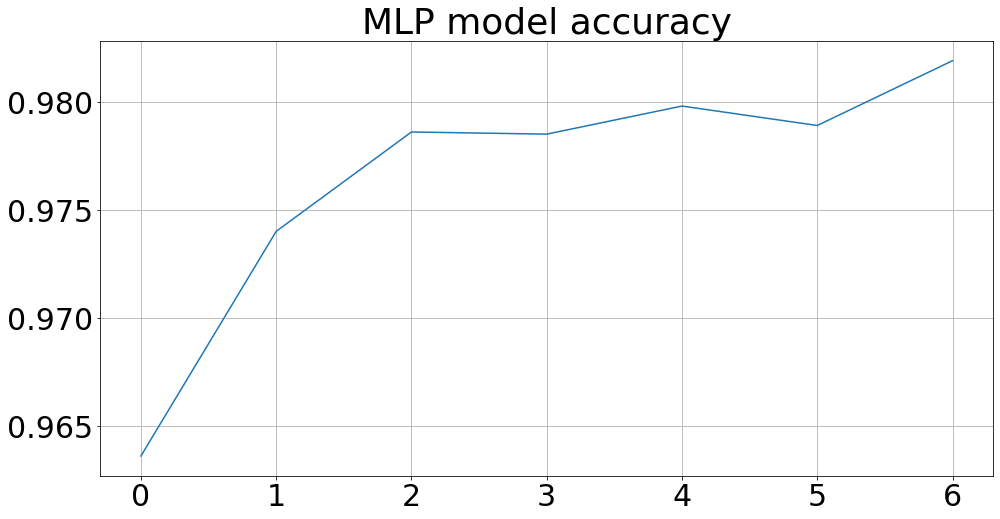

Total training and evaluation time 70.00385


In [57]:
# обучаем сетку

num_epochs = 7

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(model_fcn, data_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn)

    valid_loss, valid_accuracy = evaluate(model_fcn, test_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()



plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [58]:
# coхраняем результат обучения в файл

torch.save(model_fcn.state_dict(), 'fullyconn.pkl')

In [56]:
# чтобы сделать reset параметров: 

for layer in model_fcn.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

## 10 задание

Обучите сверточную нейронную сеть для классификации на датасете MNIST. Добейтесь качества в 99.3% на тестовой выборке.

Можете использовать уже написанные ранее функции train и evaluate.

Чтобы мы могли проверить вашу модель, напишите функцию, которая создает вашу модель и возвращает объект, назовите функцию create_conv_model, без аргументов. Вам понадобится сохранить веса вашей модели и сдать их в тестировщик, для этого воспользуйтесь методами torch.save и state_dict.

Создаем сеть по следующему алгоритму:
1. Сверточный слой с окном 5х5, 1 входной слой и $K$ выходных (количество шаблонов для фильтра, которые мы пытаемся найти окном). Размер изображения - 24х24
2. Функция активации ReLU 
3. Пулинг с окном 2х2. Размер изображения 12х12
4. Сверточный слой с окном 5х5, $K$ входных, $M$ выходных. Размер изображения 8х8
5. Функция активации ReLU
6. Пулинг с окном 2х2. Размер изображения 4х4  
_и дополняем полносвязным слоем_
7. Уплощение. 
8. Линейный слой. Количество входных фичей - размер изображения * кол-во выходных слоев - 4х4х64. Выходных - произвольное $N$
9. Функция активации ReLU
10. Линейный слой. Количество входных фичей - $N$, выходных - по количеству классов (в нашем случае 10 цифр - 10 классов)


In [59]:
def create_conv_model():
    return nn.Sequential( # 28x28
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), # 24x24 (padding=0 means it's off)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 12x12 

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 8x8 (padding still off)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 4x4

        nn.Flatten(),
        nn.Linear(4 * 4 * 64, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

conv_model = create_conv_model()

optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()


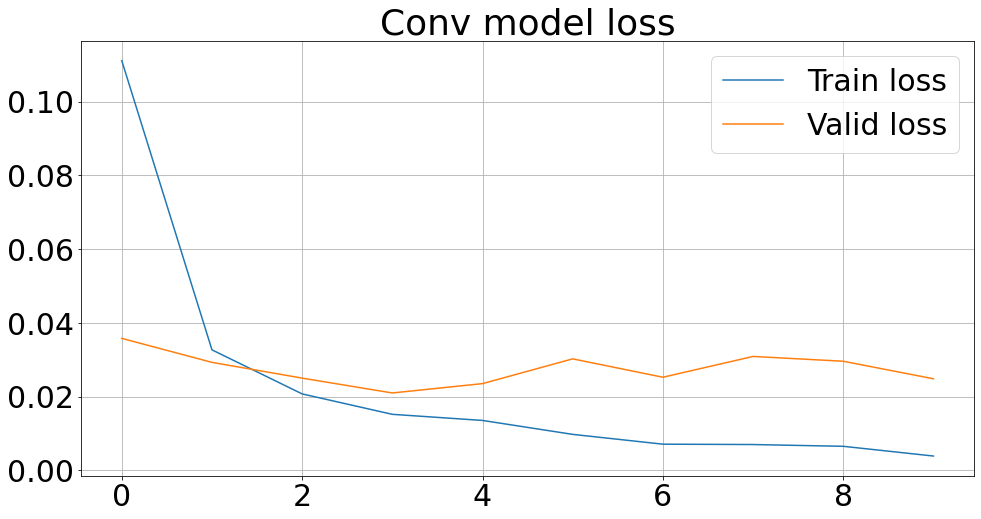

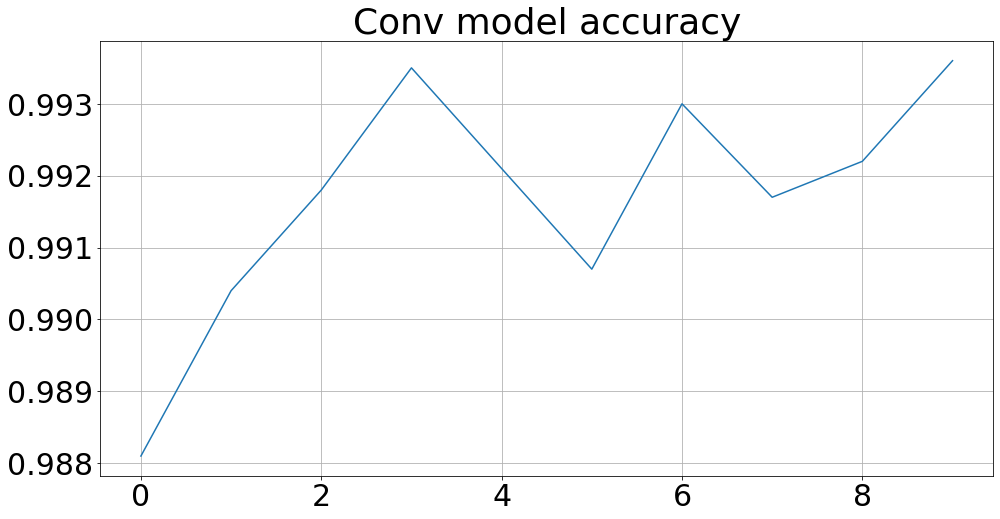

Total training and evaluation time 116.81812


In [63]:
# обучаем сетку

num_epochs = 10

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(conv_model, data_loader=train_loader,
                       optimizer=optimizer, loss_fn=loss_fn)

    valid_loss, valid_accuracy = evaluate(conv_model, test_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()


plot_stats(train_loss_history, valid_loss_history,
           valid_accuracy_history, 'Conv model')
print(f'Total training and evaluation time {perf_counter() - start:.5f}')


In [62]:
# чтобы сделать reset параметров:

for layer in conv_model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()


In [64]:
# coхраняем результат обучения в файл

torch.save(conv_model.state_dict(), 'conv.pkl')
